Dataset: https://drive.google.com/u/0/uc?id=1p33nsWQaiZMAgsruDoJLyatoq5XAH-TH&export=download

Baseline code: https://github.com/emma-sjwang/Dofe

## Algorithm Implementation

1. Implement the naive baseline model for comparison. This is typically a simple model with basic feature extraction and classification steps.

2. Choose at least one Domain Generalization (DG) method to implement and compare against the naive baseline. This could be FACT, Dofe, or another method of your choice.

3. Report the segmentation performance in terms of dice coefficient and average surface distance.

In [ ]:
# Load and unzip data
# Download from https://drive.google.com/u/0/uc?id=1p33nsWQaiZMAgsruDoJLyatoq5XAH-TH&export=download
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/Colab Notebooks/ELEC4010N/Final Project/Project2"
!unzip "/content/gdrive/MyDrive/Colab Notebooks/ELEC4010N/Final Project/Project2/Fundus-doFE.zip" -d "/content/"

# Install additional libraries
!pip install -U albumentations
!pip install segmentation-models-pytorch
!pip install torchmetrics
!git clone https://github.com/deepmind/surface-distance.git
!pip install surface-distance/
!pip install MedPy

## Naive Baseline Model

In [2]:
# Just for reference
# UNet implementation
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)      # Number of channel
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.conv_up1(x)
        out = self.last_conv(x)
        out = torch.sigmoid(out)
        
        return out

NameError: ignored

In [ ]:
# Test the model
model = UNet(num_classes=1).to(device)
output = model(torch.randn(1,3,256,256).to(device))
print(f'Output shape: {output.shape}')

## FACT

https://github.com/MediaBrain-SJTU/FACT

In [3]:
# Standard library imports
import os
import shutil
import re
import math
import copy
import gc
import random as randpy
from copy import deepcopy
from math import sqrt

# Third-party library imports
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter
from pylab import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from ast import In
import albumentations as Augm
from albumentations.pytorch import ToTensorV2

# PyTorch imports for deep learning
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torchvision.models as models
from torchvision.models import resnet50 as _resnet50
from torchsummary import summary

# Utilities for image data handling
from torchvision import transforms
from torchvision.datasets import ImageFolder

# For segmentation models
import segmentation_models_pytorch as smp

# Metrics
from medpy import metric
from segmentation_models_pytorch.losses import DiceLoss
import surface_distance as surfdist
from torchmetrics.classification import BinaryJaccardIndex

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset info
[cup]Domian1: Drishti-GS dataset [101] including training[50] and testing[51]

[cup]Domain2: RIM-ONE_r3 dataset [159] including training and[99] testing[60]. 

[cup]Domain3: REFUGE training [400]  MICCAI 2018 workshop including training and[320] testing[80]. 

[cup]Domian4: REFUGE val [400]  including training and[320] testing[80]. 
Domain5: ISBI [81]  IDRID chanllenge



In [5]:
%cd "/content"

/content


In [4]:
# Define the path to move the data
train_path = "./train"
val_path = "./val"
test_path = "./test"

# Define the path to load the data
D_mask_dir = [["./Fundus/Domain1/train/ROIs/mask", "./Fundus/Domain1/test/ROIs/mask"],
              ["./Fundus/Domain2/train/ROIs/mask", "./Fundus/Domain2/test/ROIs/mask"],
              ["./Fundus/Domain3/train/ROIs/mask", "./Fundus/Domain3/test/ROIs/mask"],
              ["./Fundus/Domain4/train/ROIs/mask", "./Fundus/Domain4/test/ROIs/mask"]]

# Define the fundus dataset class to load the data by functions
class FundusDataset(Dataset):
    # Define the constructor
    def __init__(self, path, transform, transform_mask, split_idx):
        self.path = path
        self.transform = transform
        self.transform_mask = transform_mask
        self.split_idx = split_idx
        self.path_df = self.create_path_df()
    
    # Creates a DataFrame with image and mask paths
    def create_path_df(self):
        dirsImg, images, dirsMask, masks = [], [], [], []
        
        for mask_dir in self.path:
            for img_path in mask_dir:
                for _, _, files in os.walk(img_path):
                    for file in files:
                        check_mask = cv2.imread(os.path.join(img_path, file))
                        
                        if check_mask.sum() > 0:
                            domain = re.search(r'Domain\d', img_path).group() # Extract domain
                            images.append(file)
                            masks.append(file)
                            dirsMask.append(img_path+'/')
                            dirsImg.append(img_path.replace('mask','image')+'/')

        return pd.DataFrame({'direcImg':dirsImg, 'images':images, 'direcMask':dirsMask, 'masks':masks})
    
    # Splits the train dataset into train and validation based on the split index
    def split_traindataset(self):
        for i in range(len(self.path_df)):
            image_direc = self.path_df.loc[i]['direcImg'][:-1] + '/' + self.path_df.loc[i]['images']
            mask_direc = self.path_df.loc[i]['direcMask'][:-1] + '/' + self.path_df.loc[i]['masks']
            domain = re.search(r'Domain\d', image_direc).group() if image_direc else None
            
            # Split the dataset based on the project description
            if domain:
                if domain != "Domain4":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(image_direc, destination_path + "/image/")
                    shutil.copy(mask_direc, destination_path + "/mask/")
                elif domain != "Domain3":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(image_direc, destination_path + "/image/")
                    shutil.copy(mask_direc, destination_path + "/mask/")
                elif domain != "Domain2":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(image_direc, destination_path + "/image/")
                    shutil.copy(mask_direc, destination_path + "/mask/")
                elif domain != "Domain1":
                    destination_path = train_path if i < int(0.8 * len(self.path_df)) else val_path
                    shutil.copy(image_direc, destination_path + "/image/")
                    shutil.copy(mask_direc, destination_path + "/mask/")

    # Moves the test dataset to the test path
    def split_testdataset(self):
        for i in range(len(self.path_df)):
            image_direc = self.path_df.loc[i]['direcImg'][:-1]+'/'+self.path_df.loc[i]['images']
            mask_direc = self.path_df.loc[i]['direcMask'][:-1]+'/'+self.path_df.loc[i]['masks']
            shutil.copy(image_direc, test_path+"/image/")
            shutil.copy(mask_direc, test_path+"/mask/")

    # Returns length of the dataset
    def __len__(self):
        return len(self.path_df)

    #  Creates a list of image and mask paths
    def direc(self):
        FundusImg_direc = []
        Mask_direc = []
        train_folders = os.listdir(train_path)
        
        for folder in train_folders:
            files = os.listdir(os.path.join(train_path, folder))
            
            for file in files:
                direc = os.path.join(train_path, folder, file)
                
                if 'mask' in folder:
                    Mask_direc.append(direc)
                else:
                    FundusImg_direc.append(direc)
        
        return FundusImg_direc, Mask_direc

In [6]:
# Creates the train, validation, and test folders
for path in [train_path, val_path, test_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    os.makedirs(os.path.join(path, "image"))
    os.makedirs(os.path.join(path, "mask"))

# Normalization
normalization = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.RandomCrop(64),
    transforms.ToTensor(),
])

# Create the datasets
# train = 1,2,3 test= 4
train_class = FundusDataset(D_mask_dir[1:4], transform=normalization, transform_mask=normalization, split_idx=1)
test_class = FundusDataset(D_mask_dir[:1], transform=normalization, transform_mask=normalization, split_idx=1)

# Split files of system
train_class.split_traindataset()
test_class.split_testdataset()

### data_utils.py

In [7]:
def dataset_info(filepath):
    img_direcs = []
    mask_direcs = []
    for folder in os.listdir(filepath):
        files = os.listdir(filepath+'/'+folder)
        for file in files:
            direc = filepath+'/'+folder+'/'+file
            if 'mask' in direc: mask_direcs.append(direc)
            else: img_direcs.append(direc)
    return img_direcs, mask_direcs


def get_img_transform(train=False, image_size=224, crop=False, jitter=0):
    mean = [0.5]
    std = [0.5]
    if train:
        if crop:
            img_transform = [transforms.ToPILImage(),transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0])]
        else:
            img_transform = [transforms.ToPILImage(),transforms.Resize((image_size, image_size))]
        if jitter > 0:
            img_transform.append(transforms.ColorJitter(brightness=jitter,
                                                        contrast=jitter,
                                                        saturation=jitter,
                                                        hue=min(0.5, jitter)))
        img_transform += [transforms.RandomHorizontalFlip(),
                          transforms.Normalize(mean, std)]
        img_transform = transforms.Compose(img_transform)
    else:
        img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    return img_transform

def get_label_transform(train=False, image_size=224, crop=False, jitter=0):
    mean = [0.5]
    std = [0.5]
    if train:
        if crop:
            label_transform = [transforms.ToPILImage(),transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0], interpolation=Image.NEAREST)]
        else:
            label_transform = [transforms.ToPILImage(),transforms.Resize((image_size, image_size), interpolation=Image.NEAREST)]
        if jitter > 0:
            label_transform.append(transforms.ColorJitter(brightness=jitter,
                                                        contrast=jitter,
                                                        saturation=jitter,
                                                        hue=min(0.5, jitter)))
        label_transform += [transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)]
        label_transform = transforms.Compose(label_transform)
    else:
        label_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size), interpolation=Image.NEAREST),
        ])
    return label_transform
    

def get_pre_transform(image_size=224, crop=False, jitter=0):
    if crop:
        img_transform = [transforms.ToPILImage(), transforms.RandomResizedCrop(image_size, scale=[0.8, 1.0])]
    else:
        img_transform = [transforms.ToPILImage(), transforms.Resize((image_size, image_size))]
    if jitter > 0:
        img_transform.append(transforms.ColorJitter(brightness=jitter,
                                                    contrast=jitter,
                                                    saturation=jitter,
                                                    hue=min(0.5, jitter)))
    img_transform += [transforms.RandomHorizontalFlip(), lambda x: np.asarray(x)]
    img_transform = transforms.Compose(img_transform)
    return img_transform

def get_post_transform(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return img_transform

def colorful_spectrum_mix(img1, img2, alpha, ratio=1.0):
    """Input image size: ndarray of [H, W, C]"""
    lam = np.random.uniform(0, alpha)

    assert img1.shape == img2.shape
    h, w, c = img1.shape
    h_crop = int(h * sqrt(ratio))
    w_crop = int(w * sqrt(ratio))
    h_start = h // 2 - h_crop // 2
    w_start = w // 2 - w_crop // 2

    img1_fft = np.fft.fft2(img1, axes=(0, 1))
    img2_fft = np.fft.fft2(img2, axes=(0, 1))
    img1_abs, img1_pha = np.abs(img1_fft), np.angle(img1_fft)
    img2_abs, img2_pha = np.abs(img2_fft), np.angle(img2_fft)

    img1_abs = np.fft.fftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.fftshift(img2_abs, axes=(0, 1))

    img1_abs_ = np.copy(img1_abs)
    img2_abs_ = np.copy(img2_abs)
    img1_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img2_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img1_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    img2_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img1_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img2_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]

    img1_abs = np.fft.ifftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.ifftshift(img2_abs, axes=(0, 1))

    img21 = img1_abs * (np.e ** (1j * img1_pha))
    img12 = img2_abs * (np.e ** (1j * img2_pha))
    img21 = np.real(np.fft.ifft2(img21, axes=(0, 1)))
    img12 = np.real(np.fft.ifft2(img12, axes=(0, 1)))
    img21 = np.uint8(np.clip(img21, 0, 255))
    img12 = np.uint8(np.clip(img12, 0, 255))

    return img21, img12

 ### 1.1 Data Read(Fourier) & Load 

In [8]:
class DGDataset(Dataset):
    def __init__(self, names, labels, transformer=None, lbl_transformer=None):
        self.names = names
        self.labels = labels
        self.transformer = transformer
        self.lbl_transformer = lbl_transformer

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        img_name = self.names[index]
        mask_name = self.labels[index]
        img = cv2.imread(img_name).copy()
        mask = cv2.imread(mask_name).copy()
        if self.transformer is not None:
            img = self.transformer(img)
            mask = self.lbl_transformer(mask)
        return img, mask

class FourierDGDataset(Dataset):
    def __init__(self, names, labels, transformer=None, lbl_transformer=None, from_domain=None, alpha=1.0):
        self.names = names
        self.labels = labels
        self.transformer = transformer
        self.lbl_transformer = lbl_transformer
        self.post_transform = get_post_transform()
        self.from_domain = from_domain
        self.alpha = alpha
        
        self.flat_names = []
        self.flat_labels = []
        self.flat_domains = []
        for i in range(len(names)):
            self.flat_domains += [i] * len(names[i])
            self.flat_names += names[i]
            self.flat_labels += labels[i]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        img_name = self.names[index]
        mask_name = self.labels[index]
        img = cv2.imread(img_name).copy()
        mask = cv2.imread(mask_name).copy()
        img_o = self.transformer(img)
        mask_o = self.lbl_transformer(mask)

        img_s, mask_s, _ = self.sample_image()  ## random pick image
        img_s2o, img_o2s = colorful_spectrum_mix(img_o, img_s, alpha=self.alpha)  ## mix their amplitude
        img_o, img_s = self.post_transform(img_o), self.post_transform(img_s)
        img_s2o, img_o2s = self.post_transform(img_s2o), self.post_transform(img_o2s)
        img = [img_o, img_s, img_s2o, img_o2s]  ## [original, img2, img1 x img2, img2 x img1] 
        mask = [mask_o, mask_s, mask_o, mask_s]
        # domain = [domain, domain_s, domain, domain_s]
        return img, mask

    def sample_image(self, domain=None):
        if self.from_domain == 'all':
            domain_idx = randpy.randint(0, len(self.names)-1)
        elif self.from_domain == 'inter':
            domains = list(range(len(self.names)))
            # domains.remove(domain)
            domain_idx = randpy.sample(domains, 1)[0]
        elif self.from_domain == 'intra':
            domain_idx = domain
        else:
            raise ValueError("Not implemented")
        img_idx = randpy.randint(0, len(self.names[domain_idx])-1)
        imgn_ame_sampled = self.names[img_idx]
        img_sampled = cv2.imread(imgn_ame_sampled)
        label_ame_sampled = self.labels[img_idx]
        label_sampled = cv2.imread(label_ame_sampled)
        label_sampled = self.lbl_transformer(label_sampled)
        return self.transformer(img_sampled), label_sampled, domain_idx


def get_dataset(path, train=False, image_size=64, crop=False, jitter=0):
    names, labels = dataset_info(path)
    img_transform = get_img_transform(train, image_size, crop, jitter)
    lbl_transform = get_label_transform(train, image_size=image_size, crop=crop, jitter=jitter)
    return DGDataset(names, labels, img_transform, lbl_transform)

def get_fourier_dataset(path, image_size=64, crop=False, jitter=0, from_domain='all', alpha=1.0):
    names, labels = dataset_info(path)
    img_transform = get_pre_transform(image_size, crop, jitter)
    lbl_transform = get_label_transform(train=True, image_size=image_size, crop=crop, jitter=jitter)
    return FourierDGDataset(names, labels, img_transform, lbl_transform, from_domain, alpha)



trian_path = "./train"
val_path = "./val"
test_path = "./test"

train_fourier_dataset = get_fourier_dataset(path=train_path,crop=True,jitter=0.0)
val_dataset = get_dataset(path=val_path, train=False)
test_dataset = get_dataset(path=test_path, train=False)

train_fourier_loader = torch.utils.data.DataLoader(train_fourier_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


print(f'Shape of image: {train_fourier_loader.dataset[0][0][0].numpy().shape}')
print(f'Number of training batches: {len(train_fourier_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Shape of image: (3, 64, 64)
Number of training batches: 96
Number of validation batches: 24
Number of test batches: 13


#### Show image from loader

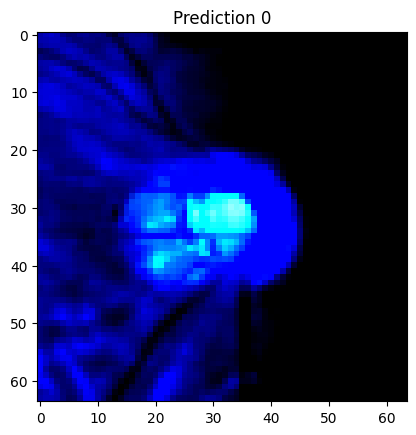

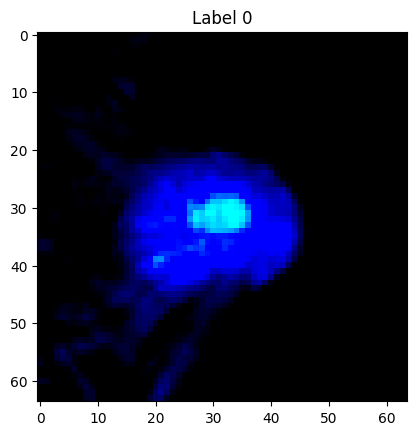

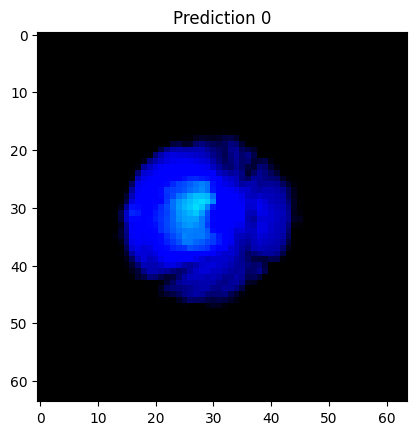

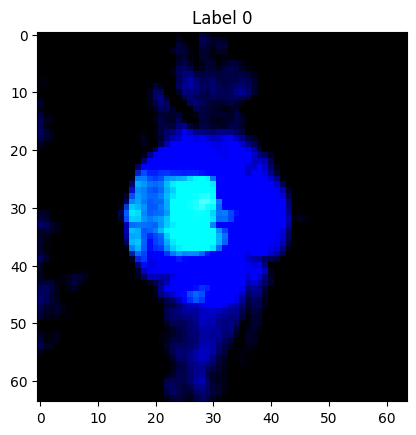

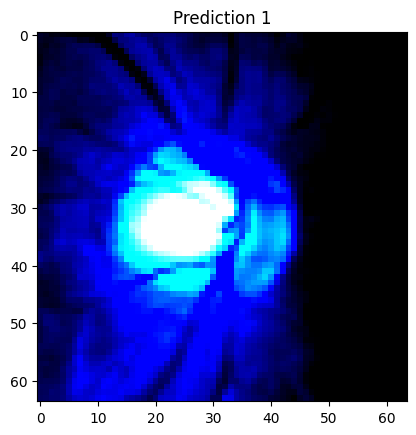

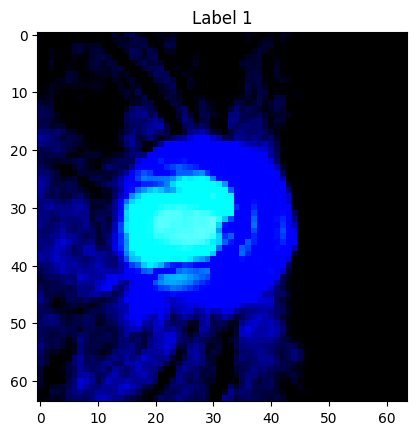

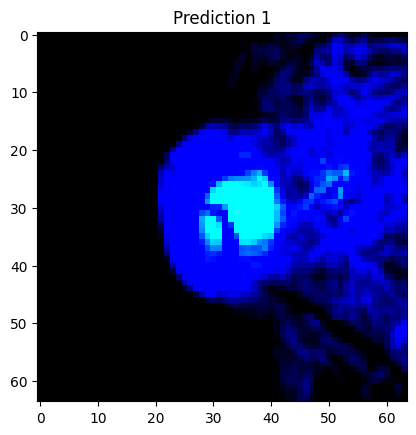

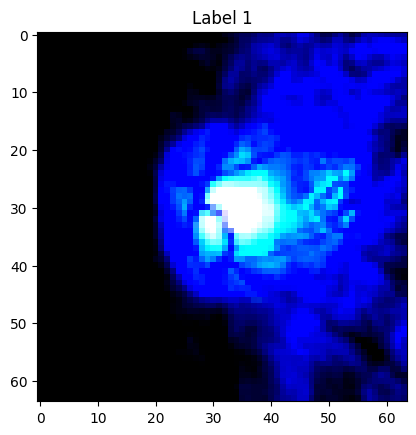

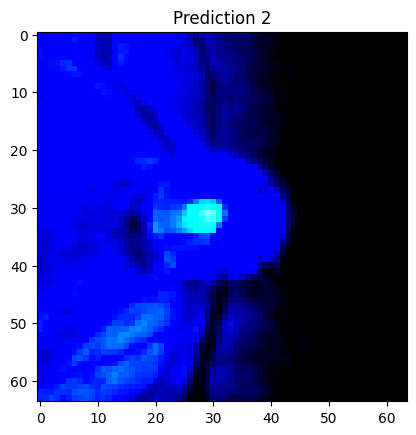

KeyboardInterrupt: ignored

In [140]:
for it, (batch, label) in enumerate(train_fourier_loader):
    batch = torch.cat(batch, dim=0).cuda()
    label = torch.cat(label, dim=0).cuda()

    split_idx = int(batch.size(0) / 2)
    ori_img, aug_img = torch.split(batch, split_idx)
    labels_ori, labels_aug = torch.split(label, split_idx)

    plt.figure()
    plt.title("Prediction "+str(it))
    image = ori_img.cpu().detach().numpy()[0]
    image = np.transpose(image, (1,2,0))
    imgplot1 = plt.imshow(image)
    plt.show(imgplot1)
    plt.figure()
    plt.title("Label "+str(it))
    image = aug_img.cpu().detach().numpy()[0]
    image = np.transpose(image, (1,2,0))
    imgplot2 = plt.imshow(image)
    plt.show(imgplot2)

    plt.figure()
    plt.title("Prediction "+str(it))
    image = ori_img.cpu().detach().numpy()[8]
    image = np.transpose(image, (1,2,0))
    imgplot1 = plt.imshow(image)
    plt.show(imgplot1)
    plt.figure()
    plt.title("Label "+str(it))
    image = aug_img.cpu().detach().numpy()[8]
    image = np.transpose(image, (1,2,0))
    imgplot2 = plt.imshow(image)
    plt.show(imgplot2)

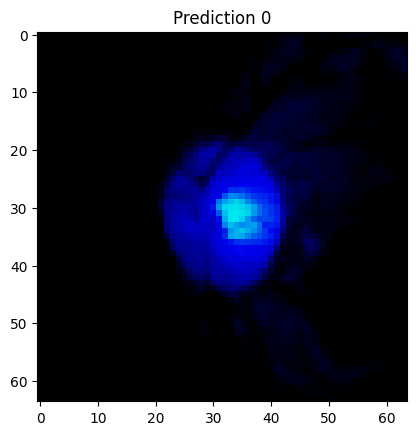

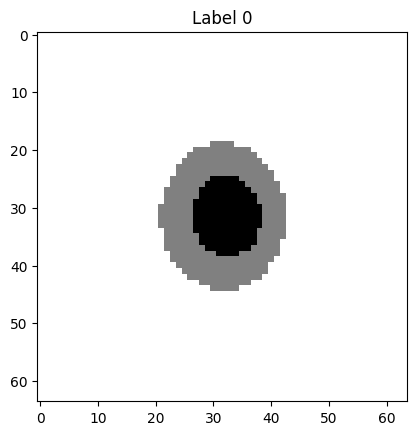

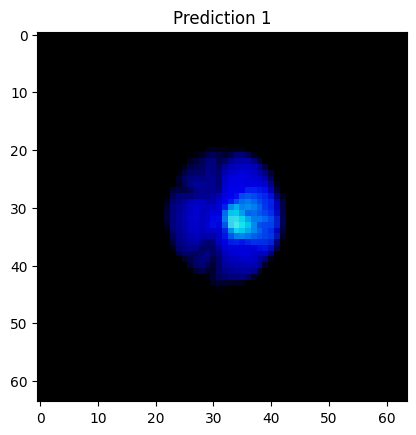

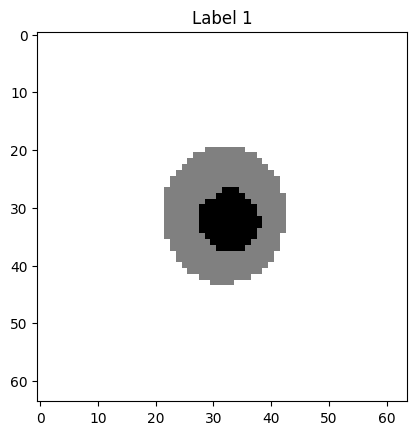

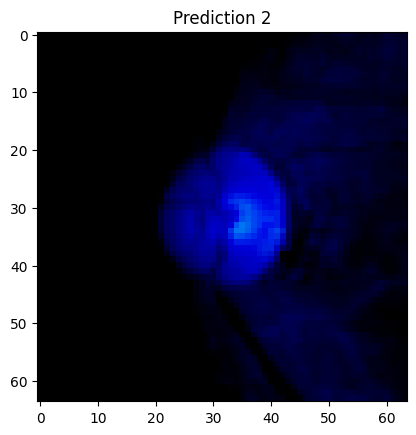

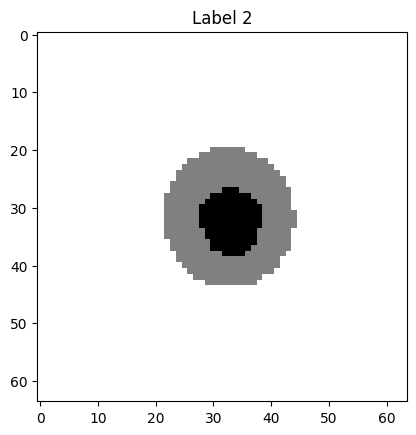

KeyboardInterrupt: ignored

In [141]:
for it, (batch) in enumerate(val_loader):
    data, labels = batch[0].to(device), batch[1].to(device)

    plt.figure()
    plt.title("Prediction "+str(it))
    image = data.cpu().detach().numpy()[0]
    image = np.transpose(image, (1,2,0))
    imgplot1 = plt.imshow(image)
    plt.show(imgplot1)
    plt.figure()
    plt.title("Label "+str(it))
    image = labels.cpu().detach().numpy()[0]
    image = np.transpose(image, (1,2,0))
    imgplot2 = plt.imshow(image)
    plt.show(imgplot2)

### 2 Build Unet2D Model

#### Mean Teacher Model

In [10]:
# Mean Teacher Model
# Student model would be ResNet50 model
class MeanTeacherModel(nn.Module):
    # Core
    def __init__(self, student_model, ema_decay):
        super().__init__()
        self.student_model = student_model
        self.teacher_model = deepcopy(student_model)
        self.ema_decay = ema_decay

    def forward(self, x):
        return self.student_model(x)

    def update_teacher_model(self, current_epoch, momentum=0.9995):
        # The momentum increases from 0 to ema_decay
        # Useful for improving quickly at the beginning
        momentum = min(1 - 1 / (current_epoch + 1), self.ema_decay)
        with torch.no_grad():
            for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
                teacher_params.data.mul_(momentum).add_((1 - momentum) * student_params.data)

    # Adjust the weight of the consistency loss to rely on teacher's prediction
    # The weight factor decreases from 1 to 0 during the first 5 epochs
    def sigmoid_rampup(self, current_epoch, rampup_len=5):
        current_epoch = np.clip(current_epoch, 0.0, rampup_len)
        phase = 1.0 - current_epoch / rampup_len
        return np.exp(-5.0 * phase * phase).astype(np.float32)

    # The weight decreases from 2
    def get_consistency_weight(self, epoch):
        return self.sigmoid_rampup(epoch)

### Medical Image Metrics

In [11]:
# Implement ASD
def compute_asd(outputs, labels):
  outputs = F.softmax(outputs,dim=1)
  outputs_cpy1, outputs_cpy2 = outputs.clone(), outputs.clone()
  labels_cpy1, labels_cpy2 = labels.clone(), labels.clone()
  ## [-1, 0.xx..., 1]
  OC, OD, BG = torch.unique(labels_cpy2)[0].item(), torch.unique(labels_cpy2)[1].item(), torch.unique(labels_cpy2)[2].item()
  mean, std, max, min = outputs.mean(), outputs.std(), torch.max(outputs), torch.min(outputs)

  ## OC asd
  labels_cpy1[labels_cpy1 == 0.0] = 2.0
  labels_cpy1[labels_cpy1 != 2.0] = 0.0
  outputs_cpy1[outputs_cpy1 > (mean-std)] = 0.0
  labels_np = labels.cpu().detach().numpy().astype(np.bool_)
  outputs_np = outputs_cpy1.cpu().detach().numpy().astype(np.bool_)
  surface_dist = surfdist.compute_surface_distances(labels_np.reshape((1,-1,labels_np.shape[3])),
                                                    outputs_np.reshape((1,-1,outputs_np.shape[3])),spacing_mm=(1.0,1.0,1.0))
  oc_avg_asd = surfdist.compute_average_surface_distance(surface_dist)[1]

  ## OD asd
  labels_cpy2[labels_cpy2 == 1.0] = 0.0
  outputs_cpy2[outputs_cpy2 < (mean-std)] = 0.0
  outputs_cpy2[outputs_cpy2 > (mean+std)] = 0.0
  labels_np = labels.cpu().detach().numpy().astype(np.bool_)
  outputs_np = outputs_cpy2.cpu().detach().numpy().astype(np.bool_)
  surface_dist = surfdist.compute_surface_distances(labels_np.reshape((1,-1,labels_np.shape[3])),
                                                    outputs_np.reshape((1,-1,outputs_np.shape[3])),spacing_mm=(1.0,1.0,1.0))
  od_avg_asd = surfdist.compute_average_surface_distance(surface_dist)[1]

  return oc_avg_asd, od_avg_asd

###3. Training

In [12]:
## Load model
Unet2D_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
)


def train_mean_teacher(model, train_loader, val_loader, optimizer, scheduler,
                       consistency_criterion, supervised_criterion, device, epochs):
    # Clear GPU cache
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

    loss_total_list, loss_sup_list, loss_con_list = [], [], []
    dice_train_list = []
    dice_val_list, asd_val_list= [], []

    model.student_model.train()
    model.teacher_model.train()

    for epoch in range(epochs):
        # Training
        loss_total_train, dice_total_train, loss_sup_train, loss_con_train = 0,0,0,0
        for it, (batch, label) in enumerate(train_loader):
            batch = torch.cat(batch, dim=0).to(device)
            label = torch.cat(label, dim=0).to(device)

            optimizer.zero_grad()

            # Get predictions
            scores = model.student_model(batch)
            with torch.no_grad():
                scores_teacher = model.teacher_model(batch)

            # Split data and predictions into original and augmented parts
            assert batch.size(0) % 2 == 0
            split_idx = int(batch.size(0) / 2)
            scores_ori, scores_aug = torch.split(scores, split_idx)
            scores_ori_tea, scores_aug_tea = torch.split(scores_teacher, split_idx)
            scores_ori_tea, scores_aug_tea = scores_ori_tea.detach(), scores_aug_tea.detach()
            labels_ori, labels_aug = torch.split(label, split_idx)
            assert scores_ori.size(0) == scores_aug.size(0)

            # Compute supervised losses for original and augmented data
            # Use KL Divergence for consistency loss
            loss_cls = supervised_criterion(scores_ori, labels_ori)
            loss_aug = supervised_criterion(scores_aug, labels_aug)

            # KL divergence
            p_ori, p_aug = F.softmax(scores_ori / 10.0, dim=1), F.softmax(scores_aug / 10.0, dim=1)
            p_ori_tea, p_aug_tea = F.softmax(scores_ori_tea / 10.0, dim=1), F.softmax(scores_aug_tea / 10.0, dim=1)
            loss_ori_tea = consistency_criterion(p_aug.log(), p_ori_tea, reduction='batchmean')
            loss_aug_tea = consistency_criterion(p_ori.log(), p_aug_tea, reduction='batchmean')
            # # MSE Loss
            # loss_ori_tea = consistency_criterion(scores_aug, scores_ori_tea)
            # loss_aug_tea = consistency_criterion(scores_ori, scores_aug_tea)

            const_weight = model.get_consistency_weight(epoch)

            # Compute total loss
            train_dice_coeff = (-0.5) * (loss_cls-1) + (-0.5) * (loss_aug-1)
            total_loss = 0.5 * loss_cls + 0.5 * loss_aug + const_weight * loss_ori_tea + const_weight * loss_aug_tea
            # print(f"loss_cls: {loss_cls:.4f},   ")
            # print(f"loss_aug: {loss_aug:.4f},   ")
            # print(f"loss_ori_tea: {loss_ori_tea:.4f},   ")
            # print(f"loss_aug_tea: {loss_aug_tea:.4f},   ")

            # Backward pass and update weights
            total_loss.backward()
            optimizer.step()

            # Update teacher model parameters
            model.update_teacher_model(current_epoch=epoch)
            loss_total_train += total_loss.item()
            loss_sup_train += 0.5*loss_cls.item() + 0.5*loss_aug.item()
            loss_con_train += const_weight*loss_aug_tea.item() + const_weight*loss_ori_tea.item()
            dice_total_train += train_dice_coeff.item()
        loss_total_list.append(loss_total_train/len(train_loader))
        loss_sup_list.append(loss_sup_train/len(train_loader))
        loss_con_list.append(loss_con_train/len(train_loader))
        dice_train_list.append(dice_total_train/len(train_loader))


        ## Validation
        model.student_model.eval()
        dice_total_val, asd_total_val = 0,0
        for it, (batch) in enumerate(val_loader):
            data, labels = batch[0].to(device), batch[1].to(device)
            scores = model.student_model(data)

            loss = supervised_criterion(scores, labels)
            oc_asd, od_asd = compute_asd(scores, labels)
            asd_ori = 0.5*oc_asd + 0.5*od_asd
            # Compute dice
            val_dice_coeff = (-1) * (loss-1)
            dice_total_val += val_dice_coeff.item()
            asd_total_val += asd_ori
        dice_val_list.append(dice_total_val/len(val_loader))
        asd_val_list.append(asd_total_val/len(val_loader))

        scheduler.step()

        # Epoch summary
        print(f"Epoch [{epoch+1:02}/{epochs}],   "
              f"Total Train Loss: {loss_total_list[-1]:.4f},   "
              f"Supervised Train Loss: {loss_sup_list[-1]:.4f},   "
              f"Const Train Loss: {loss_con_list[-1]:.4f},   "
              f"Mean Train Dice: {dice_train_list[-1]:.4f},   "
              f"Mean Val Dice: {dice_val_list[-1]:.4f},   "
              f"Mean Val ASD: {asd_val_list[-1]:.4f}   ")

        # Clear GPU cache
        if torch.cuda.is_available():
            gc.collect()
            torch.cuda.empty_cache()

    return model, loss_total_list, loss_sup_list, loss_con_list, dice_train_list, dice_val_list, asd_val_list

# Load Unet2D as Student model and Mean Teacher model
base_model = Unet2D_model.to(device)
mean_teacher_model = MeanTeacherModel(base_model, ema_decay=0.99).to(device)

# Optimizer, loss functions and scheduler
optimizer = Adam(mean_teacher_model.parameters(), lr=1e-4, weight_decay=1e-5)
consistency_criterion = F.kl_div
# consistency_criterion = nn.MSELoss()
supervised_criterion = DiceLoss(mode='multilabel', classes=3)

epochs = 25
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs)

# Run training
mean_teacher_model, loss_total_list, loss_sup_list, loss_con_list, dice_train_list, dice_val_list, asd_val_list = train_mean_teacher(
    mean_teacher_model, train_fourier_loader, val_loader, optimizer, scheduler,
    consistency_criterion, supervised_criterion, device, epochs=epochs)

MODEL_PATH = "./content"
torch.save(mean_teacher_model.state_dict(), MODEL_PATH)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 270MB/s]


Epoch [01/25],   Total Train Loss: 0.3343,   Supervised Train Loss: 0.3017,   Const Train Loss: 0.0326,   Mean Train Dice: 0.6983,   Mean Val Dice: 0.7256,   Mean Val ASD: 0.0426   
Epoch [02/25],   Total Train Loss: 0.1425,   Supervised Train Loss: 0.0791,   Const Train Loss: 0.0633,   Mean Train Dice: 0.9209,   Mean Val Dice: 0.9600,   Mean Val ASD: 0.0413   
Epoch [03/25],   Total Train Loss: 0.2299,   Supervised Train Loss: 0.0410,   Const Train Loss: 0.1889,   Mean Train Dice: 0.9590,   Mean Val Dice: 0.9509,   Mean Val ASD: 0.0446   
Epoch [04/25],   Total Train Loss: 0.4043,   Supervised Train Loss: 0.0502,   Const Train Loss: 0.3542,   Mean Train Dice: 0.9498,   Mean Val Dice: 0.9366,   Mean Val ASD: 0.0412   
Epoch [05/25],   Total Train Loss: 0.6148,   Supervised Train Loss: 0.0632,   Const Train Loss: 0.5515,   Mean Train Dice: 0.9368,   Mean Val Dice: 0.9326,   Mean Val ASD: 0.0421   
Epoch [06/25],   Total Train Loss: 0.7203,   Supervised Train Loss: 0.0763,   Const Train 

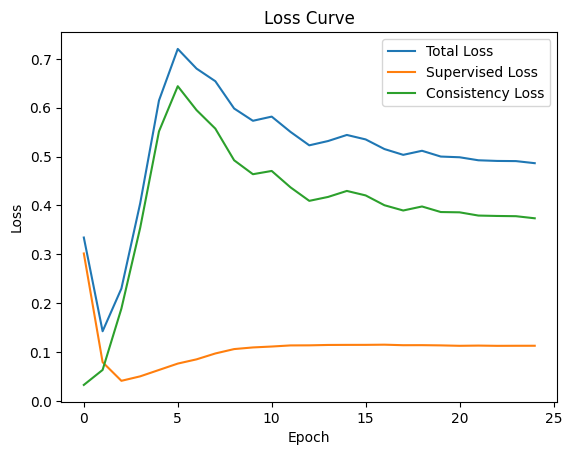

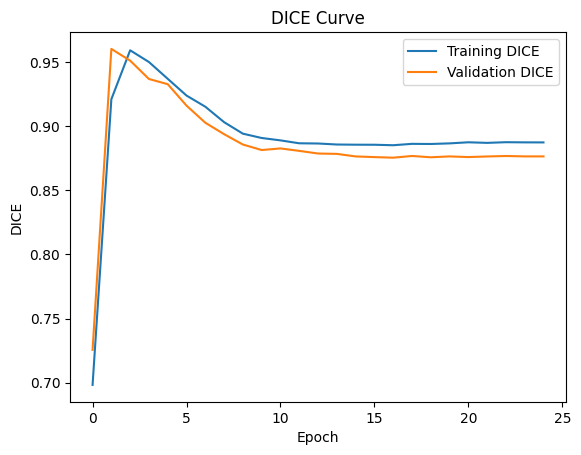

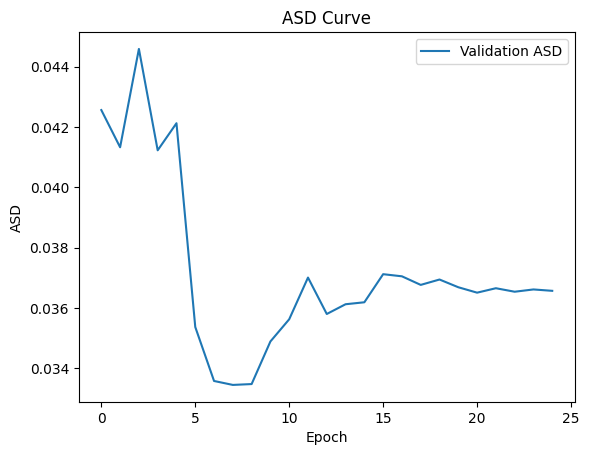

In [13]:
# Plot loss curve
fig = plt.figure()
plt.plot(loss_total_list, label='Total Loss')
plt.plot(loss_sup_list, label='Supervised Loss')
plt.plot(loss_con_list, label='Consistency Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
fig = plt.figure()
plt.plot(dice_train_list, label='Training DICE')
plt.plot(dice_val_list, label='Validation DICE')
plt.xlabel('Epoch')
plt.ylabel('DICE')
plt.title('DICE Curve')
plt.legend()
plt.show()

# Plot AUC curve
fig = plt.figure()
plt.plot(asd_val_list, label='Validation ASD')
plt.xlabel('Epoch')
plt.ylabel('ASD')
plt.title('ASD Curve')
plt.legend()
plt.show()

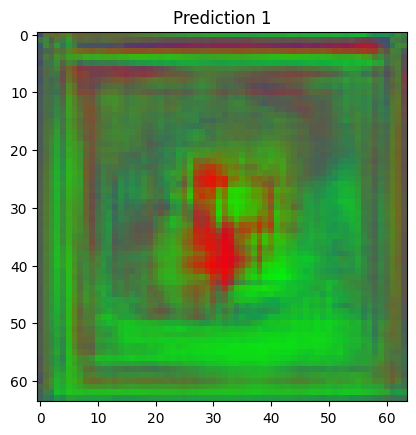

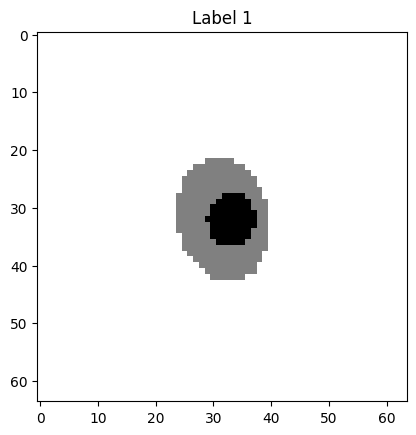

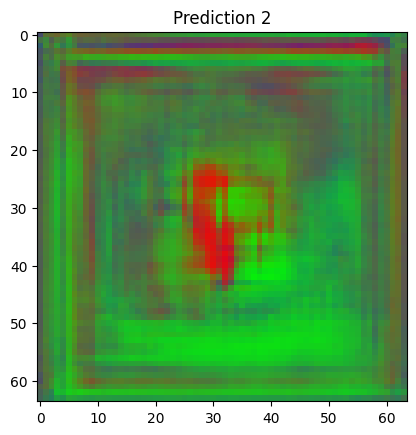

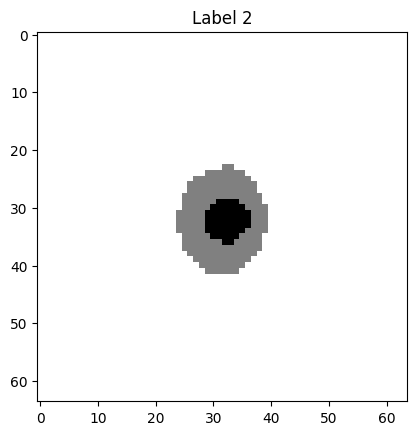

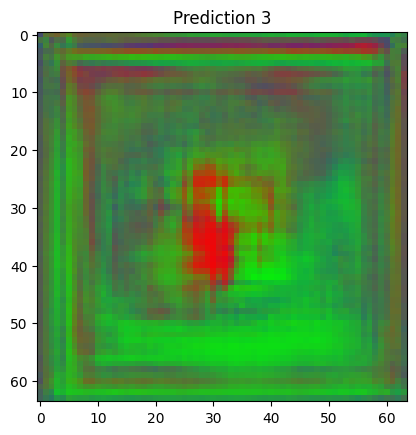

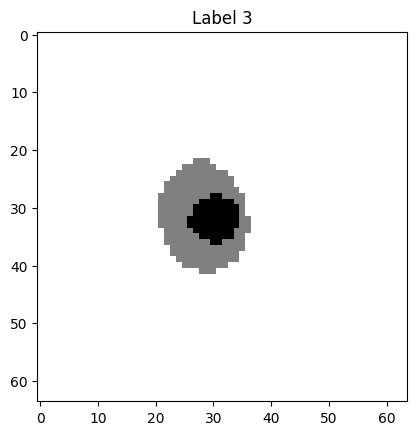

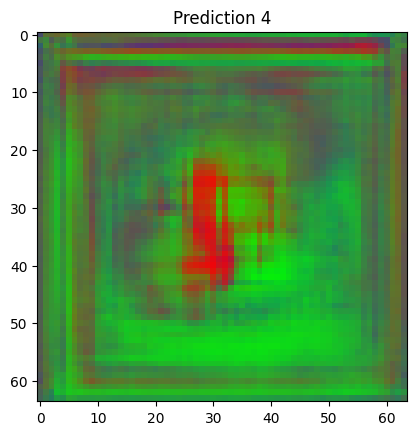

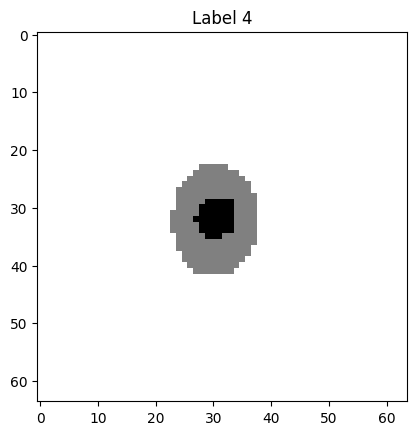

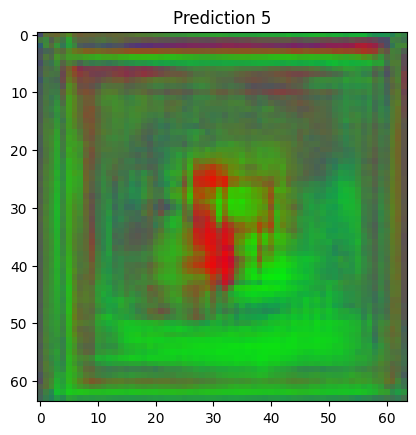

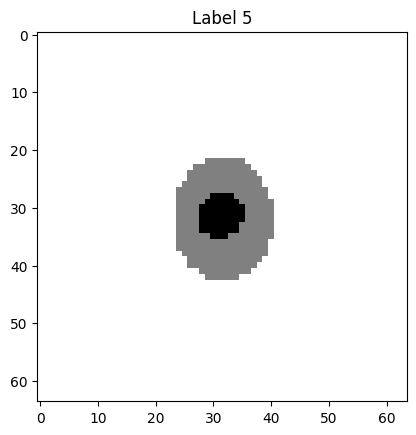

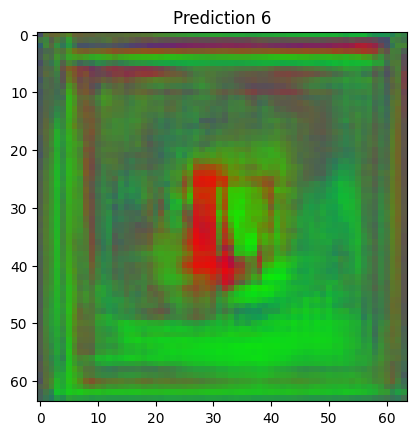

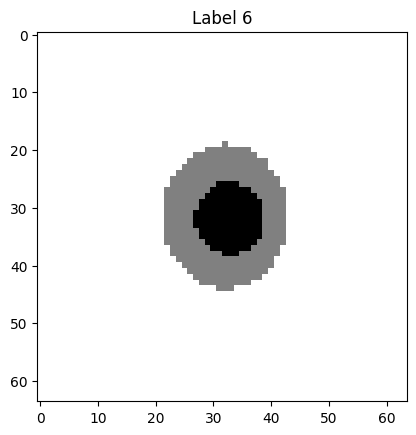

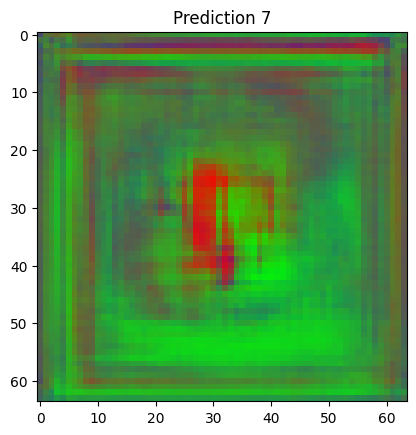

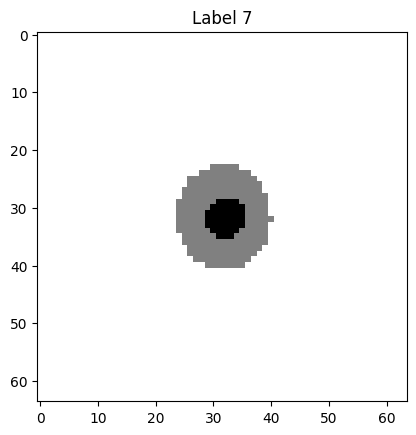

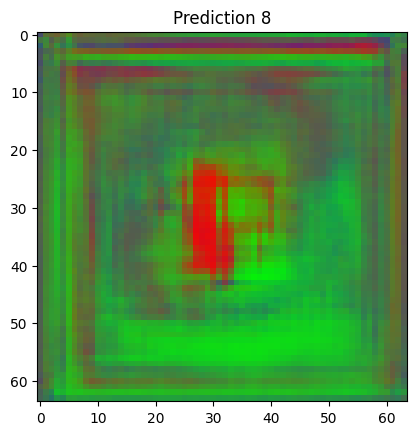

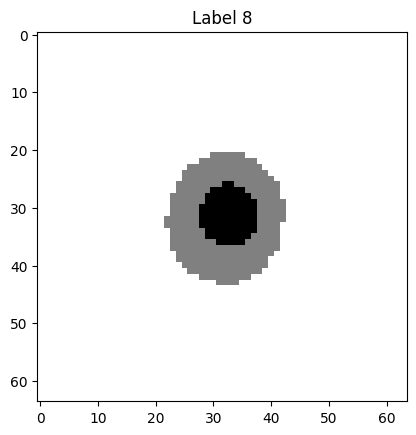

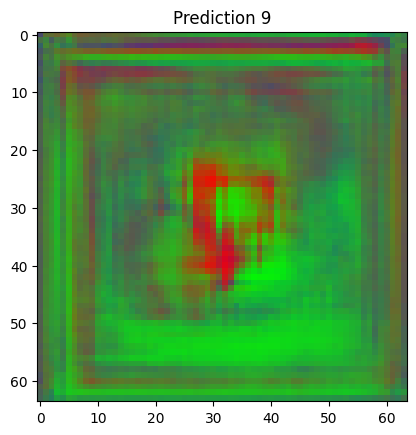

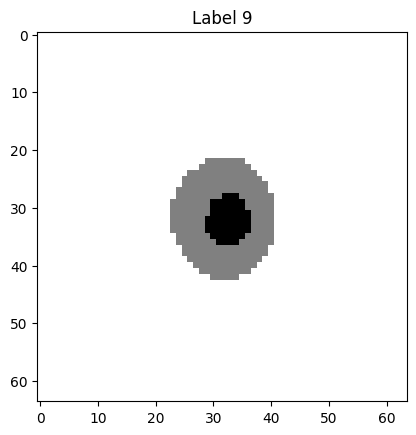

In [14]:
mean_teacher_model.load_state_dict(torch.load(MODEL_PATH))
mean_teacher_model.student_model.eval()
for it, (batch) in enumerate(val_loader):
    if it > 0 and it < 10:
        data, labels = batch[0].to(device), batch[1].to(device)
        outputs = mean_teacher_model.student_model(data)
        outputs = F.softmax(outputs,dim=1)
      
        plt.figure()
        plt.title("Prediction "+str(it))
        image = outputs.cpu().detach().numpy()[0]
        image = np.transpose(image, (1,2,0))
        imgplot1 = plt.imshow(image)
        plt.show(imgplot1)
        plt.figure()
        plt.title("Label "+str(it))
        image = labels.cpu().detach().numpy()[0]
        image = np.transpose(image, (1,2,0))
        imgplot2 = plt.imshow(image)
        plt.show(imgplot2)
